In [1]:
import os
import tensorflow as tf
import numpy as np
import matplotlib.pyplot as plt
from datetime import datetime

from utils import *
from equations import *

2023-10-30 14:46:30.538003: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F AVX512_VNNI FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-30 14:46:30.716586: I tensorflow/core/util/port.cc:104] oneDNN custom operations are on. You may see slightly different numerical results due to floating-point round-off errors from different computation orders. To turn them off, set the environment variable `TF_ENABLE_ONEDNN_OPTS=0`.
2023-10-30 14:46:30.721364: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcudart.so.11.0'; dlerror: libcudart.so.11.0: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /totten_1/chenggong/trunk-jpl/externalpackages/netcdf/install/lib:/totten_1/chenggo

In [2]:
epochADAM = 1000
epochLBFGS = 0
N_u=50
N_f=100
seed=1234
log_frequency=1000
history_frequency=10
NLayers=6
NNeurons=10
noiseLevel=[]
weights = [5,3,5,6,14]

In [3]:
hp = {}
# Data size on the solution u
hp["N_u"] = N_u
# Collocation points size, where we’ll check for f = 0
hp["N_f"] = N_f
# DeepNN topology (2-sized input [x,y], NLayers hidden layer of NNeurons-width, 1-sized output [u,v]
hp["layers"] = [2]+[NNeurons]*NLayers+[2]
# DeepNN topology (1-sized input [x,y], NLayers hidden layer of NNeurons-width, 2-sized output [h, H]
hp["h_layers"] = [2]+[NNeurons]*NLayers+[2]
# DeepNN topology (1-sized input [x,y], NLayers hidden layer of NNeurons-width, 1-sized output [C]
hp["C_layers"] = [2]+[NNeurons]*NLayers+[1]
# DeepNN topology (1-sized input [x], NLayers hidden layer of NNeurons-width, 4-sized input [u,v,C], 
#   1-sized output [taub]
hp["friction_layers"] = [3]+[NNeurons]*NLayers+[1]
# Setting up the TF SGD-based optimizer (set tf_epochs=0 to cancel it)
hp["tf_epochs"] = epochADAM
hp["tf_lr"] = 0.001
hp["tf_b1"] = 0.99
hp["tf_eps"] = 1e-1
# Setting up the quasi-newton LBGFS optimizer (set nt_epochs=0 to cancel it)
hp["nt_epochs"] = epochLBFGS
hp["log_frequency"] = log_frequency
# Record the history
hp["save_history"] = True
hp["history_frequency"] = history_frequency
# path for loading data and saving models
repoPath = "./"
appDataPath = os.path.join(repoPath, "matlab_SSA", "DATA")
path = os.path.join(appDataPath, "Helheim_Weertman_iT080_PINN_fastflow_CF.mat")

loss_weights = [10**(-w) for w in weights]

now = datetime.now()

# check the input
if type(noiseLevel) != list:
    noiseLevel = [] # set to no noise

if noiseLevel:
    modelPath = "./Models/SSA2D_3NN_"+str(NLayers)+"x"+str(NNeurons)+"_noise_" + "".join([str(i)+"_" for i in noiseLevel])+ "weights" + "".join([str(w)+"_" for w in weights]) + now.strftime("%Y%m%d_%H%M%S")
else:
    modelPath = "./Models/SSA2D_3NN_"+str(NLayers)+"x"+str(NNeurons)+"_weights"+ "".join([str(w)+"_" for w in weights]) + now.strftime("%Y%m%d_%H%M%S")

modelPath += ("_seed_" + str(seed) if seed else "")
# + "ADAM"+str(hp["tf_epochs"]) +"_BFGS"+str(hp["nt_epochs"])
reloadModel = False # reload from previous training

In [4]:
x, y, Exact_vx, Exact_vy, X_star, u_star, X_u_train, u_train, X_f, X_bc, u_bc, X_cf, n_cf, xub, xlb, uub, ulb, mu = prep_Helheim_data_all(path, hp["N_u"], hp["N_f"]) #}}}

In [5]:
logger = Logger(hp)
pinn = SSA2D_frictionNN(hp, logger, X_f,
        X_bc, u_bc,
        X_cf, n_cf,
        xub, xlb, uub, ulb,
        modelPath, reloadModel,
        mu=mu,
        loss_weights=loss_weights)

Hyperparameters:
{
  "N_u": 50,
  "N_f": 100,
  "layers": [
    2,
    10,
    10,
    10,
    10,
    10,
    10,
    2
  ],
  "h_layers": [
    2,
    10,
    10,
    10,
    10,
    10,
    10,
    2
  ],
  "C_layers": [
    2,
    10,
    10,
    10,
    10,
    10,
    10,
    1
  ],
  "friction_layers": [
    3,
    10,
    10,
    10,
    10,
    10,
    10,
    1
  ],
  "tf_epochs": 1000,
  "tf_lr": 0.001,
  "tf_b1": 0.99,
  "tf_eps": 0.1,
  "nt_epochs": 0,
  "log_frequency": 1000,
  "save_history": true,
  "history_frequency": 10
}

TensorFlow version: 2.11.0
Eager execution: True
GPU-accerelated: []


2023-10-30 14:46:32.762255: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libcuda.so.1'; dlerror: libcuda.so.1: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /totten_1/chenggong/trunk-jpl/externalpackages/netcdf/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/petsc/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/hdf5/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/proj/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/gdal/install/lib:/totten_1/chenggong/trunk-jpl/externalpackages/triangle/install/lib:/totten_1/chenggong/Elmer/install/lib:
2023-10-30 14:46:32.762273: W tensorflow/compiler/xla/stream_executor/cuda/cuda_driver.cc:265] failed call to cuInit: UNKNOWN ERROR (303)
2023-10-30 14:46:32.762290: I tensorflow/compiler/xla/stream_executor/cuda/cuda_diagnostics.cc:156] kernel driver does not appear to be running on this host (totten): /proc/driver/n

In [6]:
# error function for logger
X_u = pinn.tensor(X_star)
u = pinn.tensor(u_star)
def error():
    return pinn.test_error(X_u, u)
logger.set_error_fn(error)

In [7]:
pinn.fit(X_u_train, u_train)


Training started
Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 minmax_scale_layer (MinmaxS  (None, 2)                6         
 caleLayer)                                                      
                                                                 
 dense (Dense)               (None, 10)                30        
                                                                 
 dense_1 (Dense)             (None, 10)                110       
                                                                 
 dense_2 (Dense)             (None, 10)                110       
                                                                 
 dense_3 (Dense)             (None, 10)                110       
                                                                 
 dense_4 (Dense)             (None, 10)                110       
                                      

INFO:tensorflow:Assets written to: ./Models/SSA2D_3NN_6x10_weights5_3_5_6_14_20231030_144632_seed_1234/assets


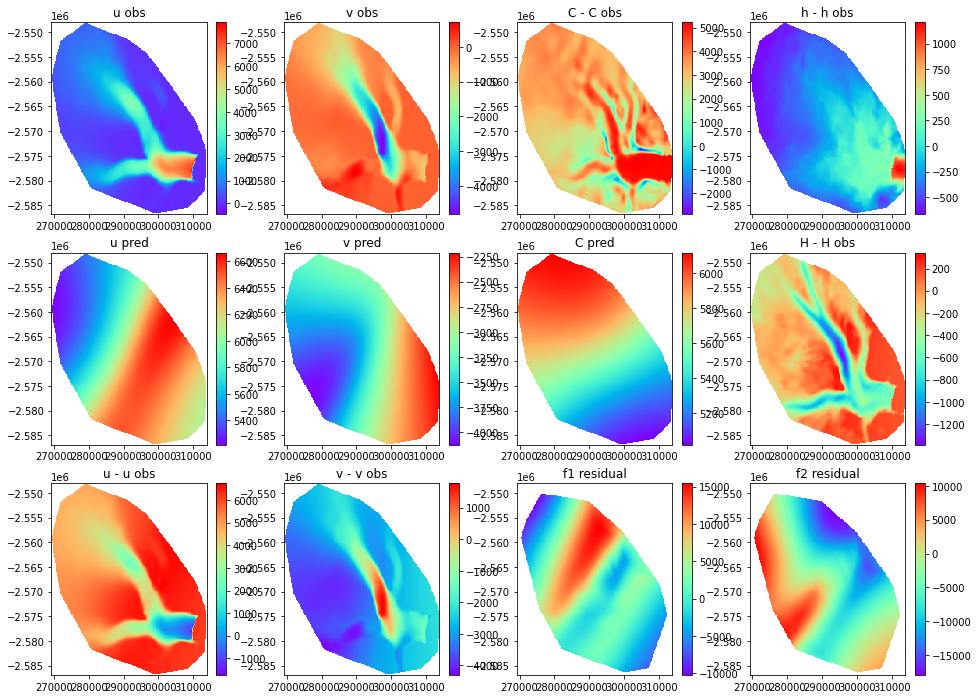

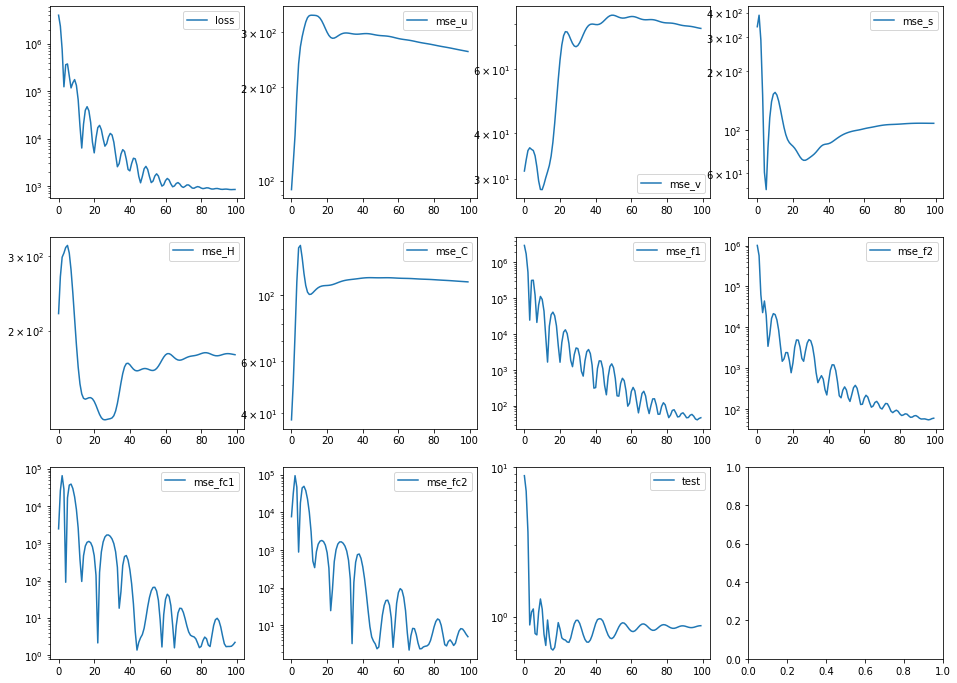

In [8]:
pinn.save()
# plot
plot_2D_solutions_all(pinn, X_f, X_star, u_star, xlb, xub, savePath=modelPath)
# history
plot_log_history(pinn, modelPath)